In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from keras import backend as K

import gym
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import sys
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random

Using plaidml.keras.backend backend.


In [2]:
env = gym.make('MountainCar-v0')

In [3]:
def get_reward(state):

    if state[0] >= 0.5:
        print("Car has reached the goal")
        return 10
    if state[0] > -0.4:
        return (1+state[0])**2
    return 0

In [4]:
class DQNAgent:
    def __init__(self, env):
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_max = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = (self.epsilon_max - self.epsilon_min) / 60
        self.discount_factor = 0.95
        self.batch_size = 64
        self.state_size = len(env.observation_space.high)
        self.action_size = env.action_space.n
        self.replay_memory = deque(maxlen=100000)
        self.model = self._build_model()
    
    def _build_model(self):
        model = Sequential([
            Dense(20, activation='relu'),
            Dense(25, activation='relu'),
            Dense(3, activation='linear')
        ])
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    def act(self, state):
        if self.epsilon_max >= self.epsilon >= self.epsilon_min:
            self.epsilon -= self.epsilon_decay
        if np.random.random() > self.epsilon:
            return np.argmax(self.model.predict(np.array([state]))[0])
        else:
            return np.random.choice(np.arange(len(self.model.predict(np.array([state]))[0])))
    
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)
    
    def update(self):
        if len(self.replay_memory) < self.batch_size:
            return

        minibatch = random.sample(self.replay_memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.discount_factor*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        
        """
        mini_batch = random.sample(self.replay_memory, min(self.batch_size, len(self.replay_memory)))
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])
        
        for state, action, reward, next_state, done in mini_batch:
            if done:
                target = reward 
            else:
                target = reward + self.discount_factor * np.amax(self.model.predict(np.array([next_state]))[0])
            target_values = self.model.predict(np.array([state]))[0]
            target_values[action] = target
            #x = np.empty([0, 0]); y = np.empty([0, 0])
            #x = np.append(x, state); y = np.append(y, target_values)
            x = np.array([state])
            y = np.array([target_values])
            self.model.fit(x=x, y=y, epochs=1, verbose=0)
        """

In [5]:
def train(agent, num_episodes):
    for i_episode in range(num_episodes):
        state = env.reset()
        episode_rewards = [0] * num_episodes
        done = False
        if (i_episode+1) % 1 == 0:
            print('\r', i_episode+1, end='')
            sys.stdout.flush()
            
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            episode_rewards[i_episode] += reward
            reward = get_reward(next_state)
            agent.update_replay_memory(tuple((state, action, reward, next_state, done)))
            agent.update()
            state = next_state
        
        print(', total reward', episode_rewards[i_episode])

agent = DQNAgent(env)                
train(agent, 100)

INFO:plaidml:Opening device "metal_intel(r)_iris(tm)_plus_graphics_640.0"


 1, total reward -200.0
 2, total reward -200.0
 3

KeyboardInterrupt: 

In [6]:
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)
X, Y = np.meshgrid(x,y)
Z = np.zeros([20,20])
for i_idx, i in enumerate(X):
    for j_idx, j in enumerate(Y):
        state = [i[i_idx],j[j_idx]]
        Z[i_idx][j_idx] = -np.max(agent.model.predict(np.array([state]))[0])

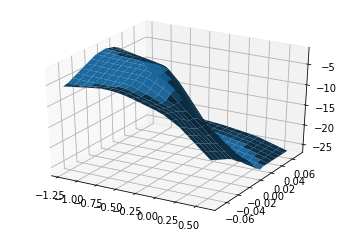

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()

In [46]:
env.observation_space.high

array([0.6 , 0.07], dtype=float32)